In [2]:
#%matplotlib
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import scipy.integrate as sc
import scipy.optimize as optimize
import scipy.interpolate

import matplotlib.pyplot as plt
import scipy.integrate as inv

import scipy.special as special
from time import time
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from scipy.stats import gmean

In [9]:
def sim(k_ind=0,
    Omega_M = 0.98,#31,
    Omega_b = 0.01,
    factor =  np.sqrt(5/9 * 15 * special.zeta(5)/special.zeta(3)),
    kvec = [1],
    mv_test = .1,
    a_end = 1,
    z = 800
     ):
    
    
    typ = "$\Lambda$CDM"
    
    if Omega_M>= 0.95:
        typ = "EdS."
    
    Omega_lambda = 1 - Omega_b - Omega_M
    #kvec = [1]#0.01,0.1,1,10,1e-5]
    #k_ind = 0
    k = kvec[k_ind]
    H0=68
    Tv_k = 1.947
    # in MeV
    h = 0.6704
    kb = 8.617e-11 # MeV/K
    T_0 = Tv_k * kb
    
    
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M,'Omega_b':Omega_b, 'k_output_values':str(kvec).strip('[]')
                 ,"N_ncdm":1,"m_ncdm":mv_test # massen er givet i eV s' jeg ganger min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl,mPk', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                , "YHe":0.25,
                 "gauge":"sync",
                }
    c = 3*1e5 # speed of lign in km/s
    H0 /= c # i 1/Mpc
    
    
    mv = mv_test * 1e-6
    
    
    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    pts = cosmo.get_perturbations()['scalar']
    # Here we create/import the powerspectrum values from class
    tranf = cosmo.get_transfer(z=0)
    prim = cosmo.get_primordial()
    
    
    #kvec = np.logspace(-4,np.log10(3),30)    
    """dict_uni1 = {"gauge":"sync",
                 "h":h,
                 #"N_ur": 2.03351,"N_ncdm": 1,"m_ncdm": 10.06,
                #"Omega_b":0.07,"Omega_cdm":0.252, 
                'k_output_values':str(kvec).strip('[]'),
                "z_pk":'1000.0, 0.0',
                 'P_k_max_1/Mpc':3.0,
                'output':'pCl,lCl,mPk,tCl, dTk, vTk',
                "lensing":"yes"
               }"""
    #uni1.set(dict_uni1)
    #uni1.compute()
    uni1 = cosmo

    
    def H(a,om=Omega_M,ol=Omega_lambda):
        return H0 * np.sqrt(om / a + ol* a**2)
    Tv_k = 1.947
    # in MeV
    kb = 8.617e-11 # MeV/K
    T0 = Tv_k * kb
    def Tv(a):
        return T0 / a # in MeV
    def cs(a):
        return factor * Tv(a) / mv
    def func(a,y):
        delta = y[0]
        d_delta = y[1]
        d2_delta = 3/2 * Omega_M * delta /(a**3 * (Omega_M/a + a**2 * Omega_lambda))-  3/2 * (Omega_M/a**2 +2 * a *Omega_lambda)/(Omega_M/a + a**2 * Omega_lambda )*d_delta  
        return [d_delta,d2_delta]
    
    
    print(len(kvec))
    power_array = np.zeros(len(kvec))
    delta_array = np.zeros(len(kvec))
    for k_ind, k_value in enumerate(kvec):
        #k_value*=h

        pb = pts[k_ind]
        a = pb["a"]
        cdm = pb["delta_cdm"]
        neutrino = pb["delta_ncdm[0]"]
        #plt.figure(k_ind)#np.random.randint(1,1000))
        tau = pb["tau [Mpc]"]
        a_interp = scipy.interpolate.interp1d(tau,a)
        a0 = 1/(z+1)
        delta_interp = scipy.interpolate.interp1d(a,pb["delta_cdm"])
        a_interp = scipy.interpolate.interp1d(a,tau)
        tau_interp = scipy.interpolate.interp1d(tau,a)
        delta_neutrino_class = pts[k_ind]["delta_ncdm[0]"]
        a_class = pts[k_ind]["a"]
        tau_class =  pts[k_ind]["tau [Mpc]"]
        delta_interp_neu = scipy.interpolate.interp1d(a_class,delta_neutrino_class)
        tau_interp = scipy.interpolate.interp1d(a_class,tau_class)
        delta0 = delta_interp(a0)
        print( delta0/a0)
        def func1(a,y,k):
            delta = a * delta0/a0
            #d_delta = y[1]

            delta_nu = y[0]
            d_delta_nu = y[1]

            #d2_delta = 3/2 * Omega_M * delta /(a**3 * (Omega_M/a + a**2 * Omega_lambda))-  3/2 * (Omega_M/a**2 +2 * a *Omega_lambda)/(Omega_M/a + a**2 * Omega_lambda )*d_delta  

            d2_delta_nu = 3/2 * Omega_M * delta /(a**3 * (Omega_M/a + a**2 * Omega_lambda))-  3/2 * (Omega_M/a**2 +2 * a *Omega_lambda)/(Omega_M/a + a**2 * Omega_lambda )*d_delta_nu - k**2 * cs(a)**2 /(a**2*H(a)**2)  * delta_nu


            return [d_delta_nu,d2_delta_nu]


        o = 0.00001
        #diff = (delta_interp(a0+h)-delta_interp(a0))/h

        diff = (delta_interp(a0+o/2)-delta_interp(a0-o/2))/o

        diff_neu =  (delta_interp_neu(a0+o/2)-delta_interp_neu(a0-o/2))/o
        y0 = [delta_interp_neu(a0),diff_neu]# diff]



        a_span = [a0,a_end]
        sol = sc.solve_ivp(func1, t_span = a_span, y0 = y0,args=(k,))#,t_eval=np.logspace(np.log10(a0),0,100))
        t_sol = sol.t
        #delta_sol = sol.y[0]
        
        #y0 = [delta_interp_neu(a0),diff_neu]# diff]
        #a_span = [a0,a_end]
        #sol = sc.solve_ivp(func1, t_span = a_span, y0 = y0,args=(k,))#,t_eval=np.logspace(np.log10(a0),0,100))
        #t_sol = sol.t
        
        delta_sol = sol.y[0]



        def func1(a,y,k):
            delta = a * delta0/a0
            #d_delta = y[1]

            delta_nu = y[0]
            d_delta_nu = y[1]

            #d2_delta = 3/2 * Omega_M * delta /(a**3 * (Omega_M/a + a**2 * Omega_lambda))-  3/2 * (Omega_M/a**2 +2 * a *Omega_lambda)/(Omega_M/a + a**2 * Omega_lambda )*d_delta  

            d2_delta_nu = 3/2 * Omega_M * delta /(a**3 * (Omega_M/a + a**2 * Omega_lambda))-  3/2 * (Omega_M/a**2 +2 * a *Omega_lambda)/(Omega_M/a + a**2 * Omega_lambda )*d_delta_nu - k**2 * cs(a)**2 /(a**2*H(a)**2)  * delta_nu


            return [d_delta_nu,d2_delta_nu]


        h1 = 0.00001
        #diff = (delta_interp(a0+h)-delta_interp(a0))/h

        diff = (delta_interp(a0+h1/2)-delta_interp(a0-h1/2))/h1

        diff_neu =  (delta_interp_neu(a0+h1/2)-delta_interp_neu(a0-h1/2))/h1
        y0 = [delta_interp_neu(a0),diff_neu]# diff]



        a_span = [a0,a_end]
        sol = sc.solve_ivp(func1, t_span = a_span, y0 = y0,args=(k,))#,t_eval=np.logspace(np.log10(a0),0,100))
        t_sol = sol.t
        #delta_sol = sol.y[0]
        
        
        plt.figure(k_ind)
        plt.title("k=%s"%(kvec[k_ind]))
        plt.loglog(t_sol,-delta_sol)
        plt.loglog(t_sol,-t_sol  * delta0/a0)
        plt.loglog(a_class,-delta_neutrino_class)
        delta_array[k_ind] = delta_sol[-1]
        
        pk = cosmo.pk(k_value,0)
        power_array[k_ind] = pk
    kvec = np.array(kvec)
    
    #tranf = uni1.get_transfer(z)
    d_cdm = tranf["d_m"]
    k_tranf = tranf['k (h/Mpc)'] * h
    prim = cosmo.get_primordial()['P_scalar(k)']
    k_prim = cosmo.get_primordial()['k [1/Mpc]']
    
    prim_interp =  scipy.interpolate.interp1d(k_prim, prim, fill_value="extrapolate",kind="cubic")
    
    prim_tranf = prim_interp(k_tranf)
    #print(power_array)
    d_m = tranf["d_cdm"]
    plt.figure()
    plt.loglog(k_tranf,2*np.pi**2 * (d_m)**2 * k_tranf **(-3) *prim_tranf * h**3,"--", label="cdm" )
    d_m = tranf["d_ncdm[0]"]
    
    plt.loglog(kvec*h, 2 * np.pi**2 * delta_array**2 * kvec**(-3)*prim_interp(kvec)*h**3,label="num" )
    
    plt.loglog(kvec,power_array * h**(3),label="standard")
    plt.loglog(k_tranf,2*np.pi**2 * d_m**2 * k_tranf **(-3) *prim_tranf * h**3,"--", label="neutrino" )
    plt.xlim([1e-4,4])
    print(h)
    plt.title("Matter power spectrum - using the  pk-funktion")
    plt.xlabel("k [h/Mpc]")
    plt.ylabel(r"P(k) [(hMpc)$^3$]")
    plt.legend()
    
    
    cosmo.struct_cleanup()
    return None


sim(mv_test=0.4,kvec = list(0.67*np.logspace(-4,np.log10(3),10)))

SyntaxError: ':' expected after dictionary key (3053266786.py, line 30)

In [6]:

def simuler(mv_test, # eV
            kvec,factor = 2.68,T_ini1 = 1000):
    
    Res = np.zeros(len(kvec))
    Omega_M = 0.3
    Omega_R = 7e-5
    Omega_lambda = 1 - Omega_M - Omega_R
    Tv_k = 1.947
    # in MeV
    kb = 8.617e-11 # MeV/K
    T0 = Tv_k * kb
    H0 = 67 / (3*1e5) # i 1/Mpc

    cosmo_dict ={'H0':70,  'Omega_cdm':Omega_M, 'k_output_values':str(kvec).strip('[]'), "N_ncdm":1,
                 "m_ncdm":mv_test # massen er givet i eV s' jeg min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                }

    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    pts = cosmo.get_perturbations()['scalar']
    #print(bg.keys())
    z = bg["z"]
    a = 1/(z+1)
    aend = a[-1]
    a0 = a[0]
    mv = mv_test * 1e-6
    # cs front faktoren
    


    # udregner Hubbleparameteren

    def H(a):
        return H0 * np.sqrt(Omega_lambda + Omega_M /( a **3) + Omega_R /( a**4)) 

    # udregnger tau 

    def tau_cal(a,y):
        # Vores "tids"-værdi i denne differentialligning er a
        tau = y[0]
        d_tau = 1 / (a ** 2 * H(a))
        return np.array(d_tau)

    # temperatur

    def Tv(a):
        return T0 / a # in MeV

    # lydhastighed

    def cs(a,mv,factor):
        return factor * Tv(a) / mv

    # udregn a
    def a_solve(tau,y):
        a = y[0]
        a_dt = a * a * H(a)
        return [a_dt]

    tau_init =   (1/H0) * (Omega_R ** (-0.5)) * a0


    sol_tau = sc.solve_ivp(tau_cal,t_span=[a0,aend],y0=[tau_init])
    tau = sol_tau.y[0]

    sol_a = sc.solve_ivp(a_solve,t_span=[tau[0],tau[-1]],y0=[a0])
    a_tau = sol_a.t
    a = sol_a.y[0]

    a_interp = scipy.interpolate.interp1d(a_tau,a)

    # sammenlignings data fra Class

    tranf = cosmo.get_transfer(z=0)
    #print(tranf.keys())
    prim = cosmo.get_primordial()
    u = prim["k [1/Mpc]"]
    print(f"{u=}")
    
    def cdm_func(τ,y):
        delta = y[0]
        theta = y[1]    
        a = a_interp(τ)
        d_delta   = - theta
        nabla2phi = (3/2) * H0*H0 * Omega_M * delta / a
        d_theta   =  - nabla2phi -  H(a) * theta * a
        return [d_delta,d_theta]

    
    for k_ind1,k in enumerate(kvec):
        
        
        delta_class1 = pts[k_ind1]["delta_cdm"]
        theta_class1 = pts[k_ind1]["theta_cdm"]
        tau_class1 = pts[k_ind1]["tau [Mpc]"]
        delta_neutrino_class1 = pts[k_ind1]["delta_ncdm[0]"]
        theta_neutrino_class1 = pts[k_ind1]["theta_ncdm[0]"]
        a_class1 = pts[k_ind1]["a"]

        delta_init1 = scipy.interpolate.interp1d(tau_class1,delta_class1)(T_ini1)
        theta_init1 = scipy.interpolate.interp1d(tau_class1,theta_class1)(T_ini1)
        delta_neutrino_init1 = scipy.interpolate.interp1d(tau_class1,delta_neutrino_class1)(T_ini1)
        theta_neutrino_init1 = scipy.interpolate.interp1d(tau_class1,theta_neutrino_class1)(T_ini1)
        t_span1 = [T_ini1,tau[-1]]

        y01 = [delta_init1,theta_init1]

        sol_cdm1 = sc.solve_ivp(cdm_func, t_span = t_span1, y0 = y01)

        t_cdm1 = sol_cdm1.t
        delta_cdm1 = sol_cdm1.y[0]


        delta_cdm_interp1 = scipy.interpolate.interp1d(t_cdm1,delta_cdm1)

        def neu_func(t,y,k,mv,factor):
            delta = y[0]
            theta = y[1]    
            a = a_interp(t)
            d_delta   = - theta
            delta_cdm = delta_cdm_interp1(t)
            d_theta   =  -  H(a) * a * theta - (3/2) * H0*H0 * Omega_M * delta_cdm / a  + k**2 * cs(a,mv,factor)**2 * delta 
            return [d_delta,d_theta]


        y01_neutrino = [delta_neutrino_init1,theta_neutrino_init1]
        sol_neu1 = sc.solve_ivp(neu_func, t_span = t_span1, y0 = y01_neutrino,args=(k,mv,factor))
        
        Res[k_ind1] = sol_neu1.y[0][-1]
    #print(prim.keys())

    
    k = tranf['k (h/Mpc)'] * h
    kvec = np.array(kvec)
    prim_interp = scipy.interpolate.interp1d(prim["k [1/Mpc]"],prim["P_scalar(k)"])#, fill_value="extrapolate",kind="cubic")
    plt.figure(1)
    print(len(k))
    print(h)
    print(k[0],k[15],k[65])
    plt.loglog(k[15:], 2*np.pi**2 * tranf["d_ncdm[0]"][15:]**2* k[15:]**(-3) * prim_interp(k[15:]) * h**3,label="neutrino")
    plt.loglog(k[15:], 2*np.pi**2 * tranf["d_m"][15:]** 2 *k[15:]**(-3) *  prim_interp(k[15:]) * h**3,label="matter")
    plt.loglog(kvec,2*np.pi**2 * Res**2 * kvec**(-3) * prim_interp(kvec)*h**3,label="min")
    plt.title("mv = %s eV T_ini = %s cs-factor = %s "%(mv_test,T_ini1,factor))
    plt.legend()
    
    plt.xlim([1e-6,1e0])

    return None
mv_test = 1e-1
kvec = list(np.logspace(-5,0,15))
simuler(mv_test, # eV
        kvec,factor = 2.68,T_ini1 = 100)

ModuleNotFoundError: No module named 'delta_neutrino_numerical_solution_til_del_3_til_specialtet'

30
0.6704
30
0.6704
30
0.6704
30
0.6704


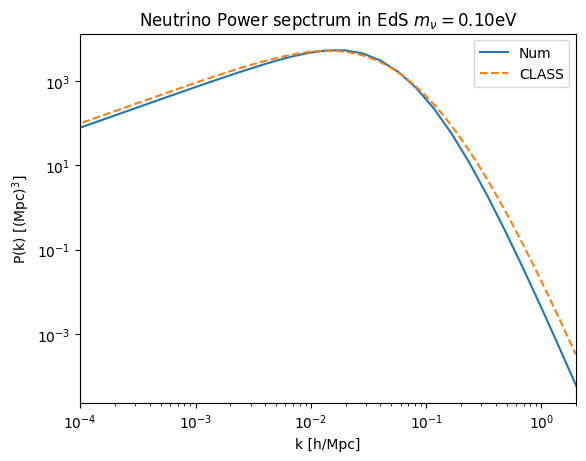

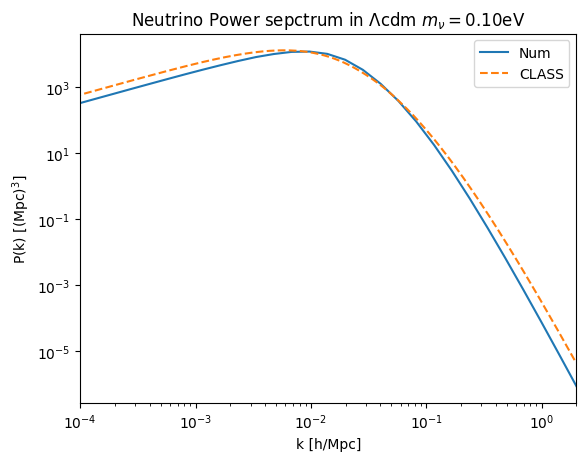

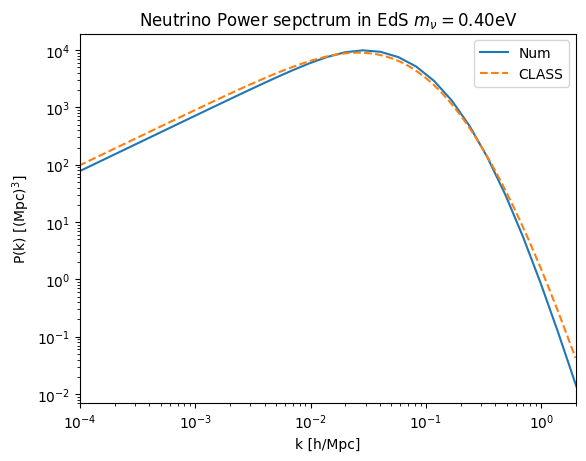

<Figure size 640x480 with 0 Axes>

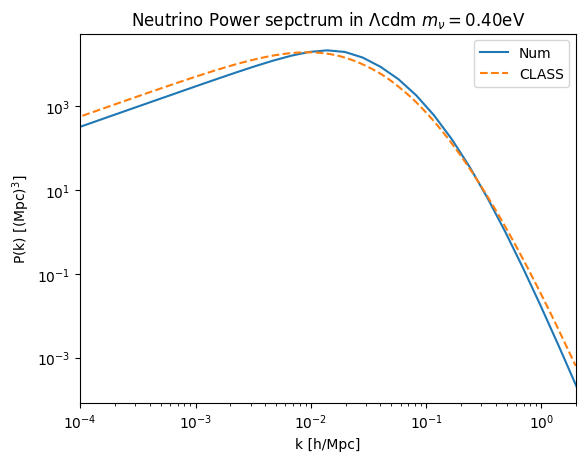

In [112]:
def f1(k_ind=0,
    Omega_M = 0.31,
    Omega_b = 0.01,
    factor =  np.sqrt(5/9 * 15 * special.zeta(5)/special.zeta(3)),
    kvec = [1],
    mv_test = .1,
    a_end = 1,
    z = 800
     ):
    
    
    typ = "$\Lambda$CDM"
    
    if Omega_M>= 0.95:
        typ = "EdS."
    
    Omega_lambda = 1 - Omega_b - Omega_M
    #kvec = [1]#0.01,0.1,1,10,1e-5]
    #k_ind = 0
    k = kvec[k_ind]
    H0=68
    Tv_k = 1.947
    # in MeV
    h = 0.6704
    kb = 8.617e-11 # MeV/K
    T_0 = Tv_k * kb
    
    
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M,'Omega_b':Omega_b, 'k_output_values':str(kvec).strip('[]')
                 ,"N_ncdm":1,"m_ncdm":mv_test # massen er givet i eV s' jeg ganger min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl, mPk', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                , "YHe":0.25,
                 "gauge":"sync",
                }
    c = 3*1e5 # speed of lign in km/s
    H0 /= c # i 1/Mpc
    
    
    mv = mv_test * 1e-6
    
    
    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    pts = cosmo.get_perturbations()['scalar']
    
    
    Tv_k = 1.947
    # in MeV
    kb = 8.617e-11 # MeV/K
    T0 = Tv_k * kb
    # 
    

    def Tv(a):
        return T0 / a # in MeV

    # lydhastighed

    def cs(a):
        return factor * Tv(a) / mv
    
    # Here we create/import the powerspectrum values from class
    tranf = cosmo.get_transfer(z=0)
    prim = cosmo.get_primordial()
    
    
    def t(k_ind):
        pb = pts[k_ind]
        a = pb["a"]
        cdm = pb["delta_cdm"]
        neutrino = pb["delta_ncdm[0]"]
        tau = pb["tau [Mpc]"]
        a_interp = scipy.interpolate.interp1d(tau,a)

        a0 = 1/(z+1)
        delta_interp = scipy.interpolate.interp1d(a,pb["delta_cdm"])


        a_interp = scipy.interpolate.interp1d(a,tau)
        tau_interp = scipy.interpolate.interp1d(tau,a)



        delta_neutrino_class = pts[k_ind]["delta_ncdm[0]"]
        a_class = pts[k_ind]["a"]
        tau_class =  pts[k_ind]["tau [Mpc]"]

        delta_interp_neu = scipy.interpolate.interp1d(a_class,delta_neutrino_class)
        #delta_cdm =  scipy.interpolate.interp1d(a_class,delta_class)
        tau_interp = scipy.interpolate.interp1d(a_class,tau_class)


        delta0 = delta_interp(a0)

        def H(a,om=Omega_M,ol=Omega_lambda):
            return H0 * np.sqrt(om / a + ol* a**2)




        def func(a,y):
            delta = y[0]
            d_delta = y[1]
            d2_delta = 3/2 * Omega_M * delta /(a**3 * (Omega_M/a + a**2 * Omega_lambda))-  3/2 * (Omega_M/a**2 +2 * a *Omega_lambda)/(Omega_M/a + a**2 * Omega_lambda )*d_delta  
            return [d_delta,d2_delta]


        def func1(a,y,k):
            delta = y[0]# a * delta0/a0
            d_delta = y[1]

            delta_nu = y[2]
            d_delta_nu = y[3]

            d2_delta = 3/2 * Omega_M * delta /(a**3 * (Omega_M/a + a**2 * Omega_lambda))-  3/2 * (Omega_M/a**2 +2 * a *Omega_lambda)/(Omega_M/a + a**2 * Omega_lambda )*d_delta  

            d2_delta_nu = 3/2 * Omega_M * delta /(a**3 * (Omega_M/a + a**2 * Omega_lambda))-  3/2 * (Omega_M/a**2 +2 * a *Omega_lambda)/(Omega_M/a + a**2 * Omega_lambda )*d_delta_nu - k**2 * cs(a)**2 /(a**2*H(a)**2)  * delta_nu


            return [d_delta,d2_delta,d_delta_nu,d2_delta_nu]


        o = 0.00001
        diff = (delta_interp(a0+o)-delta_interp(a0))/o

        diff = (delta_interp(a0+o/2)-delta_interp(a0-o/2))/o

        diff_neu =  (delta_interp_neu(a0+o/2)-delta_interp_neu(a0-o/2))/o
        y0 = [delta_interp(a0),diff,delta_interp_neu(a0),diff_neu]# diff]



        a_span = [a0,a_end]
        sol = sc.solve_ivp(func1, t_span = a_span, y0 = y0,args=(kvec[k_ind],))#,t_eval=np.logspace(np.log10(a0),0,100))
        delta_neu_sol = sol.y[2]
        t_sol = sol.t
        """plt.figure(k_ind) 

        
        plt.loglog(t_sol, - t_sol * delta0/a0,"-.",lw=2,label="cdm approx.")
        plt.loglog(t_sol,-delta_neu_sol,"-.",label=r"Num. Neu. $m_{\nu}=$%seV " % (mv_test))
        plt.loglog(t_sol,-sol.y[0],"-.",label=r"Num. Neu. $m_{\nu}=$%seV " % (mv_test))
        plt.loglog(a_class,-delta_neutrino_class,label=r"CLASS Neu. $m_{\nu}=$%seV " % (mv_test))
        """
    
        return delta_neu_sol[-1]
    
        
    
    print(len(kvec))
    power_array = np.zeros(len(kvec))
    delta_array = np.zeros(len(kvec))
    for k_ind, k_value in enumerate(kvec):
        #k_value*=h
        #t(k_ind)
        delta_array[k_ind] = t(k_ind)
        pk = cosmo.pk(k_value,0)
        power_array[k_ind] = pk
    kvec = np.array(kvec)
    
    
    plt.figure(12312)
    d_cdm = tranf["d_m"]
    k_tranf = tranf['k (h/Mpc)'] * h
    prim = cosmo.get_primordial()['P_scalar(k)']
    k_prim = cosmo.get_primordial()['k [1/Mpc]']
    prim_interp =  scipy.interpolate.interp1d(k_prim, prim, fill_value="extrapolate",kind="cubic")
    prim_tranf = prim_interp(k_tranf)
    d_m = tranf["d_cdm"]
    plt.figure()
    plt.loglog(kvec,2*np.pi**2 * delta_array**2 * kvec**(-3)* prim_interp(kvec)*h**3,label="Num")
    #plt.loglog(k_tranf,2*np.pi**2 * (d_m)**2 * k_tranf **(-3) *prim_tranf * h**3,"--", label="cdm" )
    d_m = tranf["d_ncdm[0]"]
    plt.loglog(k_tranf,2*np.pi**2 * d_m**2 * k_tranf **(-3) *prim_tranf * h**3,"--", label="CLASS" )
    plt.xlim([1e-4,4])
    print(h)
    typ = "$\Lambda$cdm"
    if Omega_M >= 0.92:
        typ = "EdS"
    plt.title(r"Neutrino Power spectrum in %s $m_{\nu}=$%.2feV" %(typ,mv_test))
    plt.xlabel("k [h/Mpc]")
    plt.ylabel(r"P(k) [(Mpc)$^3$]")
    plt.xlim([1e-4,2])
    plt.legend()
    plt.savefig("neutrino_power_spectrum_mv=%.2f with omegaM=%s.png"%((mv_test),Omega_M))
    
    
    cosmo.struct_cleanup()
    return None
f1(Omega_M = 0.98,kvec = list(0.67*np.logspace(-4,np.log10(3),30)),k_ind=-1)
f1(Omega_M = 0.31,kvec = list(0.67*np.logspace(-4,np.log10(3),30)),k_ind=-1)

f1(Omega_M = 0.98,kvec = list(0.67*np.logspace(-4,np.log10(3),30)),k_ind=-1,mv_test=0.4)
f1(Omega_M = 0.31,kvec = list(0.67*np.logspace(-4,np.log10(3),30)),k_ind=-1,mv_test=0.4)

10
0.6704


<Figure size 640x480 with 0 Axes>

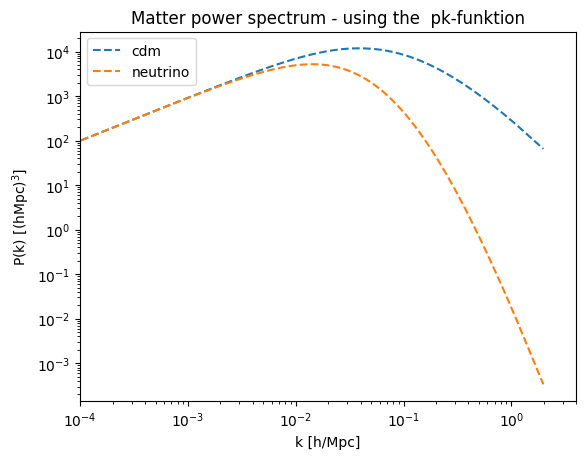

<Figure size 640x480 with 0 Axes>

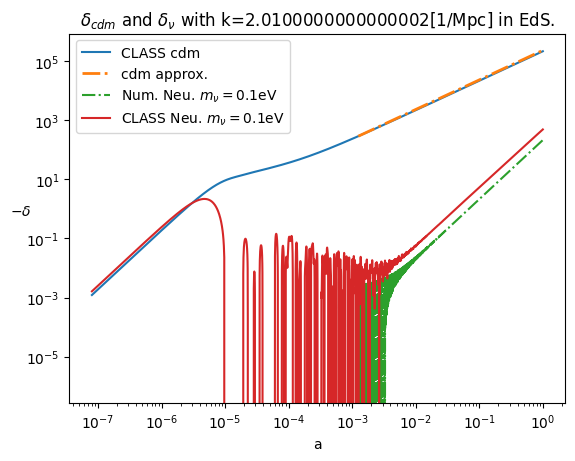

In [85]:
def f1(k_ind=0,
    Omega_M = 0.31,
    Omega_b = 0.01,
    factor =  np.sqrt(5/9 * 15 * special.zeta(5)/special.zeta(3)),
    kvec = [1],
    mv_test = .1,
    a_end = 1,
    z = 800
     ):
    
    
    typ = "$\Lambda$CDM"
    
    if Omega_M>= 0.95:
        typ = "EdS."
    
    Omega_lambda = 1 - Omega_b - Omega_M
    #kvec = [1]#0.01,0.1,1,10,1e-5]
    #k_ind = 0
    k = kvec[k_ind]
    H0=68
    Tv_k = 1.947
    # in MeV
    h = 0.6704
    kb = 8.617e-11 # MeV/K
    T_0 = Tv_k * kb
    
    
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M,'Omega_b':Omega_b, 'k_output_values':str(kvec).strip('[]')
                 ,"N_ncdm":1,"m_ncdm":mv_test # massen er givet i eV s' jeg ganger min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl,', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                , "YHe":0.25,
                 "gauge":"sync",
                }
    c = 3*1e5 # speed of lign in km/s
    H0 /= c # i 1/Mpc
    
    
    mv = mv_test * 1e-6
    
    
    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    pts = cosmo.get_perturbations()['scalar']
    
    
    Tv_k = 1.947
    # in MeV
    kb = 8.617e-11 # MeV/K
    T0 = Tv_k * kb
    # 
    

    def Tv(a):
        return T0 / a # in MeV

    # lydhastighed

    def cs(a):
        return factor * Tv(a) / mv
    
    # Here we create/import the powerspectrum values from class
    tranf = cosmo.get_transfer(z=0)
    prim = cosmo.get_primordial()
    
    
    def t():
        pb = pts[k_ind]
        a = pb["a"]
        cdm = pb["delta_cdm"]
        neutrino = pb["delta_ncdm[0]"]
        plt.figure(k_ind)#np.random.randint(1,1000))
        tau = pb["tau [Mpc]"]
        a_interp = scipy.interpolate.interp1d(tau,a)

        a0 = 1/(z+1)
        delta_interp = scipy.interpolate.interp1d(a,pb["delta_cdm"])


        a_interp = scipy.interpolate.interp1d(a,tau)
        tau_interp = scipy.interpolate.interp1d(tau,a)



        delta_neutrino_class = pts[k_ind]["delta_ncdm[0]"]
        a_class = pts[k_ind]["a"]
        tau_class =  pts[k_ind]["tau [Mpc]"]

        delta_interp_neu = scipy.interpolate.interp1d(a_class,delta_neutrino_class)
        #delta_cdm =  scipy.interpolate.interp1d(a_class,delta_class)
        tau_interp = scipy.interpolate.interp1d(a_class,tau_class)


        delta0 = delta_interp(a0)

        def H(a,om=Omega_M,ol=Omega_lambda):
            return H0 * np.sqrt(om / a + ol* a**2)




        def func(a,y):
            delta = y[0]
            d_delta = y[1]
            d2_delta = 3/2 * Omega_M * delta /(a**3 * (Omega_M/a + a**2 * Omega_lambda))-  3/2 * (Omega_M/a**2 +2 * a *Omega_lambda)/(Omega_M/a + a**2 * Omega_lambda )*d_delta  
            return [d_delta,d2_delta]


        def func1(a,y,k):
            delta = a * delta0/a0
            #d_delta = y[1]

            delta_nu = y[0]
            d_delta_nu = y[1]

            #d2_delta = 3/2 * Omega_M * delta /(a**3 * (Omega_M/a + a**2 * Omega_lambda))-  3/2 * (Omega_M/a**2 +2 * a *Omega_lambda)/(Omega_M/a + a**2 * Omega_lambda )*d_delta  

            d2_delta_nu = 3/2 * Omega_M * delta /(a**3 * (Omega_M/a + a**2 * Omega_lambda))-  3/2 * (Omega_M/a**2 +2 * a *Omega_lambda)/(Omega_M/a + a**2 * Omega_lambda )*d_delta_nu - k**2 * cs(a)**2 /(a**2*H(a)**2)  * delta_nu


            return [d_delta_nu,d2_delta_nu]


        o = 0.00001
        #diff = (delta_interp(a0+h)-delta_interp(a0))/h

        diff = (delta_interp(a0+o/2)-delta_interp(a0-o/2))/o

        diff_neu =  (delta_interp_neu(a0+o/2)-delta_interp_neu(a0-o/2))/o
        y0 = [delta_interp_neu(a0),diff_neu]# diff]



        a_span = [a0,a_end]
        sol = sc.solve_ivp(func1, t_span = a_span, y0 = y0,args=(kvec[k_ind],))#,t_eval=np.logspace(np.log10(a0),0,100))
        t_sol = sol.t
        #delta_sol = sol.y[0]


        plt.figure(np.random.randint(1,100000))

        plt.loglog(a_class,-cdm,label="CLASS cdm")
        #plt.loglog(t_sol,-delta_sol,"-.",lw=2,label=r"Num. cdm  $m_{\nu}=$%seV."%mv_test)


        delta_neu_sol = sol.y[0]
        plt.loglog(t_sol, - t_sol * delta0/a0,"-.",lw=2,label="cdm approx.")
        plt.loglog(t_sol,-delta_neu_sol,"-.",label=r"Num. Neu. $m_{\nu}=$%seV " % (mv_test))
        plt.loglog(a_class,-delta_neutrino_class,label=r"CLASS Neu. $m_{\nu}=$%seV " % (mv_test))

        plt.ylabel("$-\delta$",rotation=0)
        #plt.xlim([2e-8,1])
        #print(a0)
        plt.legend()
        plt.title(r"$\delta_{cdm}$ and $\delta_{\nu}$ with k=%s[1/Mpc] in %s"%(k,typ)) #using a cs-factor = %.2ffactor
        plt.xlabel("a")
    
    
    
        
    
    print(len(kvec))
    power_array = np.zeros(len(kvec))
    delta_array = np.zeros(len(kvec))
    plt.figure(12312)
    d_cdm = tranf["d_m"]
    k_tranf = tranf['k (h/Mpc)'] * h
    prim = cosmo.get_primordial()['P_scalar(k)']
    k_prim = cosmo.get_primordial()['k [1/Mpc]']
    prim_interp =  scipy.interpolate.interp1d(k_prim, prim, fill_value="extrapolate",kind="cubic")
    prim_tranf = prim_interp(k_tranf)
    d_m = tranf["d_cdm"]
    plt.figure()
    plt.loglog(k_tranf,2*np.pi**2 * (d_m)**2 * k_tranf **(-3) *prim_tranf * h**3,"--", label="cdm" )
    d_m = tranf["d_ncdm[0]"]
    plt.loglog(k_tranf,2*np.pi**2 * d_m**2 * k_tranf **(-3) *prim_tranf * h**3,"--", label="neutrino" )
    plt.xlim([1e-4,4])
    print(h)
    plt.title("Matter power spectrum - using the  pk-funktion")
    plt.xlabel("k [h/Mpc]")
    plt.ylabel(r"P(k) [(hMpc)$^3$]")
    plt.legend()
    t()
    
    cosmo.struct_cleanup()
    return None
f1(Omega_M = 0.98,kvec = list(0.67*np.logspace(-4,np.log10(3),10)),k_ind=-1)

30
0.6704
30
0.6704
30
0.6704
30
0.6704


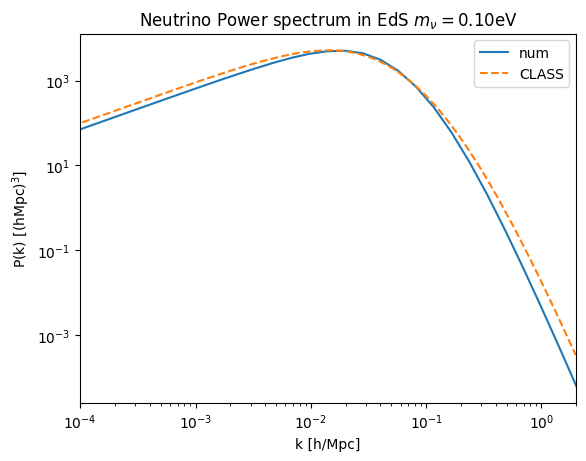

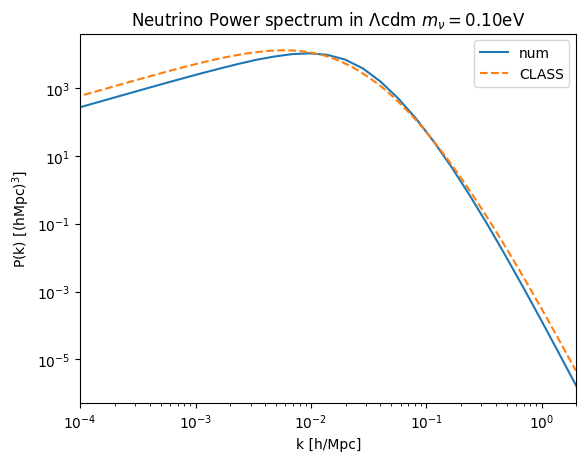

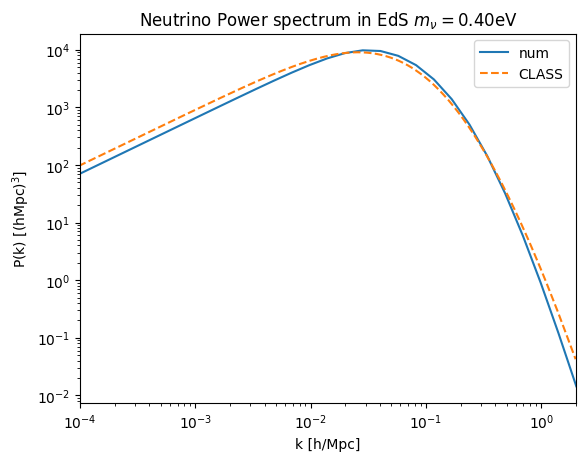

<Figure size 640x480 with 0 Axes>

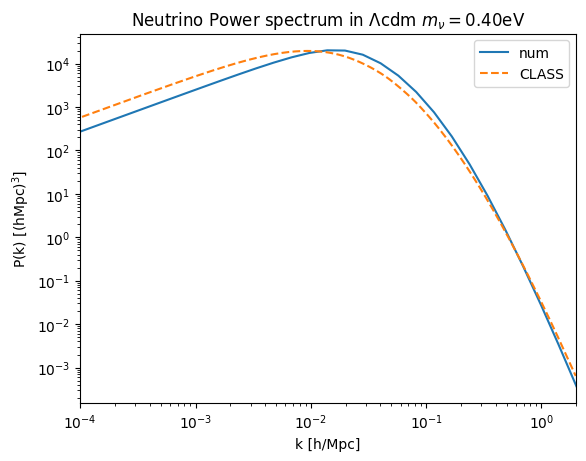

In [115]:
def f1(k_ind=0,
    Omega_M = 0.31,
    Omega_b = 0.01,
    factor =  np.sqrt(5/9 * 15 * special.zeta(5)/special.zeta(3)),
    kvec = [1],
    mv_test = .1,
    a_end = 1,
    z = 800
     ):
    
    
    typ = "$\Lambda$CDM"
    
    if Omega_M>= 0.95:
        typ = "EdS."
    
    Omega_lambda = 1 - Omega_b - Omega_M
    #kvec = [1]#0.01,0.1,1,10,1e-5]
    #k_ind = 0
    k = kvec[k_ind]
    H0=68
    Tv_k = 1.947
    # in MeV
    h = 0.6704
    kb = 8.617e-11 # MeV/K
    T_0 = Tv_k * kb
    
    
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M,'Omega_b':Omega_b, 'k_output_values':str(kvec).strip('[]')
                 ,"N_ncdm":1,"m_ncdm":mv_test # massen er givet i eV s' jeg ganger min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl, mPk', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                , "YHe":0.25,
                 "gauge":"sync",
                }
    c = 3*1e5 # speed of lign in km/s
    H0 /= c # i 1/Mpc
    
    
    mv = mv_test * 1e-6
    
    
    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    pts = cosmo.get_perturbations()['scalar']
    
    
    Tv_k = 1.947
    # in MeV
    kb = 8.617e-11 # MeV/K
    T0 = Tv_k * kb
    # 
    

    def Tv(a):
        return T0 / a # in MeV

    # lydhastighed

    def cs(a):
        return factor * Tv(a) / mv
    
    # Here we create/import the powerspectrum values from class
    tranf = cosmo.get_transfer(z=0)
    prim = cosmo.get_primordial()
    
    
    def t(k_ind):
        pb = pts[k_ind]
        a = pb["a"]
        cdm = pb["delta_cdm"]
        neutrino = pb["delta_ncdm[0]"]
        #plt.figure(k_ind)#np.random.randint(1,1000))
        tau = pb["tau [Mpc]"]
        a_interp = scipy.interpolate.interp1d(tau,a)

        a0 = 1/(z+1)
        delta_interp = scipy.interpolate.interp1d(a,pb["delta_cdm"])


        a_interp = scipy.interpolate.interp1d(a,tau)
        tau_interp = scipy.interpolate.interp1d(tau,a)



        delta_neutrino_class = pts[k_ind]["delta_ncdm[0]"]
        a_class = pts[k_ind]["a"]
        tau_class =  pts[k_ind]["tau [Mpc]"]

        delta_interp_neu = scipy.interpolate.interp1d(a_class,delta_neutrino_class)
        tau_interp = scipy.interpolate.interp1d(a_class,tau_class)


        delta0 = delta_interp(a0)

        def H(a,om=Omega_M,ol=Omega_lambda):
            return H0 * np.sqrt(om / a + ol* a**2)
        def func(a,y):
            delta = y[0]
            d_delta = y[1]
            d2_delta = 3/2 * Omega_M * delta /(a**3 * (Omega_M/a + a**2 * Omega_lambda))-  3/2 * (Omega_M/a**2 +2 * a *Omega_lambda)/(Omega_M/a + a**2 * Omega_lambda )*d_delta  
            return [d_delta,d2_delta]


        def func1(a,y,k):
            delta = a * delta0/a0
            delta_nu = y[0]
            d_delta_nu = y[1]
            d2_delta_nu = 3/2 * Omega_M * delta /(a**3 * (Omega_M/a + a**2 * Omega_lambda))-  3/2 * (Omega_M/a**2 +2 * a *Omega_lambda)/(Omega_M/a + a**2 * Omega_lambda )*d_delta_nu - k**2 * cs(a)**2 /(a**2*H(a)**2)  * delta_nu
            return [d_delta_nu,d2_delta_nu]
        o = 0.00001
        diff_neu =  (delta_interp_neu(a0+o/2)-delta_interp_neu(a0-o/2))/o
        y0 = [delta_interp_neu(a0),diff_neu]# diff]
        a_span = [a0,a_end]
        sol = sc.solve_ivp(func1, t_span = a_span, y0 = y0,args=(kvec[k_ind],))#,t_eval=np.logspace(np.log10(a0),0,100))
        delta_neu_sol = sol.y[0]
        
         
    
        return delta_neu_sol[-1]
    
        
    
    print(len(kvec))
    power_array = np.zeros(len(kvec))
    delta_array = np.zeros(len(kvec))
    for k_ind, k_value in enumerate(kvec):
        #k_value*=h
        #t(k_ind)
        delta_array[k_ind] = t(k_ind)
        pk = cosmo.pk(k_value,0)
        power_array[k_ind] = pk
    kvec = np.array(kvec)
    
    
    plt.figure(12312)
    d_cdm = tranf["d_m"]
    k_tranf = tranf['k (h/Mpc)'] * h
    prim = cosmo.get_primordial()['P_scalar(k)']
    k_prim = cosmo.get_primordial()['k [1/Mpc]']
    prim_interp =  scipy.interpolate.interp1d(k_prim, prim, fill_value="extrapolate",kind="cubic")
    prim_tranf = prim_interp(k_tranf)
    d_m = tranf["d_cdm"]
    plt.figure(np.random.randint(1,111111113))
    plt.loglog(kvec,2*np.pi**2 * delta_array**2 * kvec**(-3)* prim_interp(kvec)*h**3,label="num")
    #plt.loglog(k_tranf,2*np.pi**2 * (d_m)**2 * k_tranf **(-3) *prim_tranf * h**3,"--", label="cdm" )
    d_m = tranf["d_ncdm[0]"]
    plt.loglog(k_tranf,2*np.pi**2 * d_m**2 * k_tranf **(-3) *prim_tranf * h**3,"--", label="CLASS" )
    plt.xlim([1e-4,4])
    print(h)
    
    typ = "$\Lambda$cdm"
    if Omega_M >= 0.92:
        typ = "EdS"
    plt.title(r"Neutrino Power spectrum in %s $m_{\nu}=$%.2feV" %(typ,mv_test))
    plt.xlabel("k [h/Mpc]")
    plt.ylabel(r"P(k) [(hMpc)$^3$]")
    plt.legend()
    plt.xlim([1e-4,2])
    plt.legend()
    plt.savefig("neutrino_power_spectrum_mv=%.2f with approx omegaM=%s.png"%((mv_test),Omega_M))
    
    
    cosmo.struct_cleanup()
    return None

f1(Omega_M = 0.98,kvec = list(0.67*np.logspace(-4,np.log10(3),30)),k_ind=-1)
f1(Omega_M = 0.31,kvec = list(0.67*np.logspace(-4,np.log10(3),30)),k_ind=-1)

f1(Omega_M = 0.98,kvec = list(0.67*np.logspace(-4,np.log10(3),30)),k_ind=-1,mv_test=0.4)
f1(Omega_M = 0.31,kvec = list(0.67*np.logspace(-4,np.log10(3),30)),k_ind=-1,mv_test=0.4)

30
0.6704
30
0.6704


<Figure size 640x480 with 0 Axes>

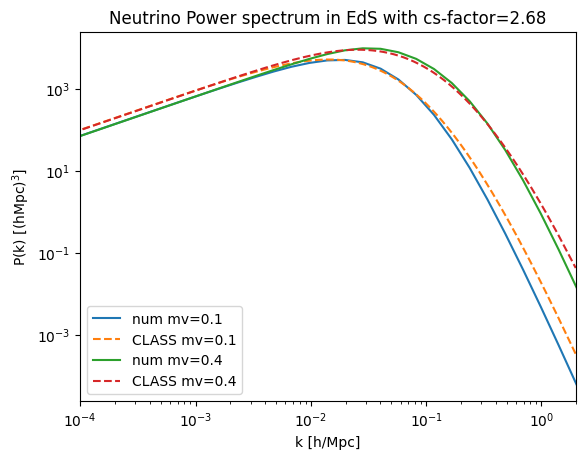

In [36]:
def f1(k_ind=0,
    Omega_M = 0.31,
    Omega_b = 0.01,
    factor =  np.sqrt(5/9 * 15 * special.zeta(5)/special.zeta(3)),
    kvec = [1],
    mv_test = .1,
    a_end = 1,
    z = 800,
    fignum=1
     ):
    typ = "$\Lambda$CDM"
    if Omega_M>= 0.95:
        typ = "EdS."
    
    Omega_lambda = 1 - Omega_b - Omega_M
    #kvec = [1]#0.01,0.1,1,10,1e-5]
    #k_ind = 0
    k = kvec[k_ind]
    H0=68
    Tv_k = 1.947
    # in MeV
    h = 0.6704
    kb = 8.617e-11 # MeV/K
    T_0 = Tv_k * kb
    
    
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M,'Omega_b':Omega_b, 'k_output_values':str(kvec).strip('[]')
                 ,"N_ncdm":1,"m_ncdm":mv_test # massen er givet i eV s' jeg ganger min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl, mPk', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                , "YHe":0.25,
                 "gauge":"sync",
                }
    c = 3*1e5 # speed of lign in km/s
    H0 /= c # i 1/Mpc
    
    
    mv = mv_test * 1e-6
    
    
    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    pts = cosmo.get_perturbations()['scalar']
    
    
    Tv_k = 1.947
    # in MeV
    kb = 8.617e-11 # MeV/K
    T0 = Tv_k * kb
    # 
    

    def Tv(a):
        return T0 / a # in MeV

    # lydhastighed

    def cs(a):
        return factor * Tv(a) / mv
    
    # Here we create/import the powerspectrum values from class
    tranf = cosmo.get_transfer(z=0)
    prim = cosmo.get_primordial()
    
    
    def t(k_ind):
        pb = pts[k_ind]
        a = pb["a"]
        cdm = pb["delta_cdm"]
        neutrino = pb["delta_ncdm[0]"]
        #plt.figure(k_ind)#np.random.randint(1,1000))
        tau = pb["tau [Mpc]"]
        a_interp = scipy.interpolate.interp1d(tau,a)

        a0 = 1/(z+1)
        delta_interp = scipy.interpolate.interp1d(a,pb["delta_cdm"])


        a_interp = scipy.interpolate.interp1d(a,tau)
        tau_interp = scipy.interpolate.interp1d(tau,a)



        delta_neutrino_class = pts[k_ind]["delta_ncdm[0]"]
        a_class = pts[k_ind]["a"]
        tau_class =  pts[k_ind]["tau [Mpc]"]

        delta_interp_neu = scipy.interpolate.interp1d(a_class,delta_neutrino_class)
        tau_interp = scipy.interpolate.interp1d(a_class,tau_class)


        delta0 = delta_interp(a0)

        def H(a,om=Omega_M,ol=Omega_lambda):
            return H0 * np.sqrt(om / a + ol* a**2)
        def func(a,y):
            delta = y[0]
            d_delta = y[1]
            d2_delta = 3/2 * Omega_M * delta /(a**3 * (Omega_M/a + a**2 * Omega_lambda))-  3/2 * (Omega_M/a**2 +2 * a *Omega_lambda)/(Omega_M/a + a**2 * Omega_lambda )*d_delta  
            return [d_delta,d2_delta]


        def func1(a,y,k):
            delta = a * delta0/a0
            delta_nu = y[0]
            d_delta_nu = y[1]
            d2_delta_nu = 3/2 * Omega_M * delta /(a**3 * (Omega_M/a + a**2 * Omega_lambda))-  3/2 * (Omega_M/a**2 +2 * a *Omega_lambda)/(Omega_M/a + a**2 * Omega_lambda )*d_delta_nu - k**2 * cs(a)**2 /(a**2*H(a)**2)  * delta_nu
            return [d_delta_nu,d2_delta_nu]
        o = 0.00001
        diff_neu =  (delta_interp_neu(a0+o/2)-delta_interp_neu(a0-o/2))/o
        y0 = [delta_interp_neu(a0),diff_neu]# diff]
        a_span = [a0,a_end]
        sol = sc.solve_ivp(func1, t_span = a_span, y0 = y0,args=(kvec[k_ind],))#,t_eval=np.logspace(np.log10(a0),0,100))
        delta_neu_sol = sol.y[0]
        
         
    
        return delta_neu_sol[-1]
    
        
    
    print(len(kvec))
    power_array = np.zeros(len(kvec))
    delta_array = np.zeros(len(kvec))
    for k_ind, k_value in enumerate(kvec):
        #k_value*=h
        #t(k_ind)
        delta_array[k_ind] = t(k_ind)
        pk = cosmo.pk(k_value,0)
        power_array[k_ind] = pk
    kvec = np.array(kvec)
    
    
    plt.figure(12312)
    d_cdm = tranf["d_m"]
    k_tranf = tranf['k (h/Mpc)'] * h
    prim = cosmo.get_primordial()['P_scalar(k)']
    k_prim = cosmo.get_primordial()['k [1/Mpc]']
    prim_interp =  scipy.interpolate.interp1d(k_prim, prim, fill_value="extrapolate",kind="cubic")
    prim_tranf = prim_interp(k_tranf)
    d_m = tranf["d_cdm"]
    plt.figure(fignum)
    plt.loglog(kvec,2*np.pi**2 * delta_array**2 * kvec**(-3)*h**3* prim_interp(kvec),label="num mv=%s"%mv_test)#* prim_interp(kvec)
    #plt.loglog(k_tranf,2*np.pi**2 * (d_m)**2 * k_tranf **(-3) *prim_tranf * h**3,"--", label="cdm" )
    d_m = tranf["d_ncdm[0]"]
    plt.loglog(k_tranf,2*np.pi**2 * d_m**2 * k_tranf **(-3) * h**3* prim_interp(k_tranf),"--", label="CLASS mv=%s"%mv_test)# *prim_tranf
    plt.xlim([1e-4,4])
    print(h)
    
    typ = "$\Lambda$cdm"
    if Omega_M >= 0.92:
        typ = "EdS"
    plt.title(r"Neutrino Power spectrum in %s with cs-factor=%.2f" %(typ,factor))
    plt.xlabel("k [h/Mpc]")
    plt.ylabel(r"P(k) [(hMpc)$^3$]")
    plt.legend()
    plt.xlim([1e-4,2])
    plt.legend()
    
    
    
    cosmo.struct_cleanup()
    return None

Omega_M = 0.98
kvec = list(0.67*np.logspace(-4,np.log10(3),30))
f1(Omega_M=Omega_M,kvec = kvec,k_ind=-1,mv_test=0.1)
f1(Omega_M=Omega_M,kvec = kvec,k_ind=-1,mv_test=0.4)
factor =  np.sqrt(5/9 * 15 * special.zeta(5)/special.zeta(3))
plt.savefig("neutrino_power_spectrum_mv=(%.2f,%.2f) with approx omegaM=%s og cs=%.2f.pdf"%(0.1,0.4,Omega_M,factor))

#f1(Omega_M = 0.31,kvec = list(0.67*np.logspace(-4,np.log10(3),30)),k_ind=-1)
#f1(Omega_M = 0.98,kvec = list(0.67*np.logspace(-4,np.log10(3),30)),k_ind=-1,mv_test=0.4)
#f1(Omega_M = 0.31,kvec = list(0.67*np.logspace(-4,np.log10(3),30)),k_ind=-1,mv_test=0.4)

30
0.6704
30
0.6704


<Figure size 640x480 with 0 Axes>

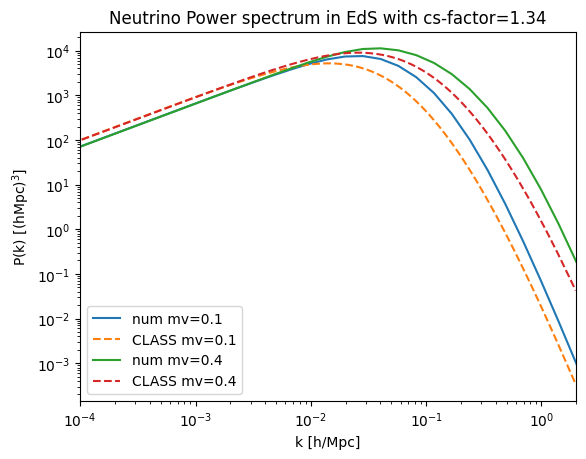

In [37]:

Omega_M = 0.98
fact =  np.sqrt(5/9 * 15 * special.zeta(5)/special.zeta(3))/2
factor =fact
kvec = list(0.67*np.logspace(-4,np.log10(3),30))
f1(Omega_M=Omega_M,kvec = kvec,k_ind=-1,mv_test=0.1,factor =fact)
f1(Omega_M=Omega_M,kvec = kvec,k_ind=-1,mv_test=0.4,factor =fact)

plt.savefig("neutrino_power_spectrum_mv=(%.2f,%.2f) with approx omegaM=%s og cs=%.2f.pdf"%(0.1,0.4,Omega_M,factor))


30
0.6704
30
0.6704


<Figure size 640x480 with 0 Axes>

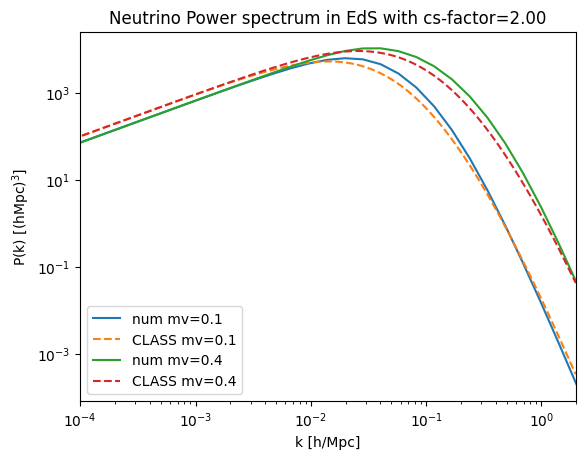

In [38]:
factor = 2
fact=factor
factor=factor
Omega_M = 0.98
kvec = list(0.67*np.logspace(-4,np.log10(3),30))
f1(Omega_M=Omega_M,kvec = kvec,k_ind=-1,mv_test=0.1,factor=factor)
f1(Omega_M=Omega_M,kvec = kvec,k_ind=-1,mv_test=0.4,factor=factor)
factor = 2# np.sqrt(5/9 * 15 * special.zeta(5)/special.zeta(3))
plt.savefig("neutrino_power_spectrum_mv=(%.2f,%.2f) with approx omegaM=%s og cs=%.2f.pdf"%(0.1,0.4,Omega_M,factor))
